## MNIST Classifier
This small project demonstrates a classifier for the MNIST dataset of handwritten numbers.
The model uses two hidden layers with leaky ReLUs, the Cross-Entropy loss function and the Adam optimizer. 

We use the pytorch library for building and training the model, torchvision for loading the datasets and matplotlib for plotting results.

In [1]:
import torch #PyTorch import
from torch import nn,functional,optim #Essentials for model
from torch.nn.functional import leaky_relu

from torchvision import transforms as tfs, datasets as dts #Import for using MNIST dataset and transforming data
from torch.utils.data import DataLoader #Loading datasets

import matplotlib.pyplot as plt #Plotting results and data

### Hyperparameters for the leaky ReLUs and the optimizer
In this part we will be defining parameters which will influence the training. They are probably not optimal, but were the best ones found in a relatively short time. 

In [2]:
leaky_relu_slope_1 = 0.02 #Slope for negative values of leakyReLU
leaky_relu_slope_2 = 0.02 #Slope for negative values of leakyReLU

adam_lr = 0.003 #Adam optimizer learning rate
adam_betas = (0.9,0.9)

### Loading and transforming data
Now the MNIST training and test datasets are downloaded and transformed to pytorch tensors.

In [3]:
transform = tfs.Compose([tfs.ToTensor()]) # Transform data to pytorch tensor

In [4]:
trainset = dts.MNIST('./MNIST_data/', download=True, train=True, transform=transform) # 60000 labeled training images
testset = dts.MNIST('./MNIST_data/', download=True, train=False, transform=transform) # 10000 labeled test images

The data is loaded in batches for quicker and more efficient calculations.

In [5]:
batch_size = 64 # Size for batches of data loaded in the DataLoader

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True) # Load in 60000/batch_size batches (tensors)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True) # Load in 10000/batch_size batches (tensors)

### Creating the model
The next step is defining the neural network/model with 784 input nodes (one node for each pixel) and 10 output nodes for classification. The model uses two hidden layers and leakyReLU functions with a negative slope defined in the hyperparameters above.

In [6]:
class Network(nn.Module):
    def __init__(self):
        """
        Initialize the network. Define layers
        
        :return: None
        """
        super(Network, self).__init__()
        self.hidden_layer_1 = nn.Linear(28 * 28, 512)
        self.hidden_layer_2 = nn.Linear(512, 512)
        
        self.output_layer = nn.Linear(512, 10)
    
    def forward(self, input):
        """
        Feeds data into the network and returns values of the output nodes.
        
        :param input: Tensor of dimensions (batch_size, 784)
        :return: Tensor of dimensions (batch_size, 10)
        """
        input = leaky_relu(self.hidden_layer_1(input), leaky_relu_slope_1) # Leaky ReLU for first hidden layer
        input = leaky_relu(self.hidden_layer_2(input), leaky_relu_slope_2) # Leaky ReLU for second hidden layer
        
        output = self.output_layer(input)
        return output

model = Network()

Here the loss function and optimizer are defined using hyperparameters declared above. 

In [7]:
criterion = nn.CrossEntropyLoss() #Loss function CrossEntropyLoss = -log(Softmax)
optimizer = optim.Adam(model.parameters(),lr=adam_lr,betas=adam_betas) #Adam optimizer

### Training and testing the model
Now we train and test the network in epochs. Loss on training and test data are shown for every epoch, as well as average accuracy of predictions on the test dataset.
Losses for every epoch are stored in a list for plotting them later.

In [8]:
epochs = 10

training_losses = []
test_losses = []

for epoch in range(epochs):
    print('Epoch:', str(epoch+1) + '/' + str(epochs))
    
    #Training
    training_loss = 0
    for images, labels in trainloader:
        images = images.view(images.shape[0],-1) #Flatten images from 2D to 1D
        
        optimizer.zero_grad() #Set gradients to zero
        
        predictions = model(images)
        
        loss = criterion(predictions, labels)
        loss.backward()
        
        optimizer.step()
        
        training_loss += loss.item()
    
    training_losses.append(training_loss/len(trainloader))
    print('>  Training Loss:', str(round(training_loss/len(trainloader), 3)))
    
    #Test
    test_loss = 0
    accuracy = 0
    for images,labels in testloader:
        images = images.view(images.shape[0],-1)
                
        test_predictions = model(images)
        
        test_loss += criterion(test_predictions, labels)
                
        top_probability, top_guess = test_predictions.topk(1, dim=1) #Tensor of top guesses for each image
        guess_correct = top_guess == labels.view(top_guess.shape) #Tensor of booleans for each guess (True: correct guess, False: wrong guess)
        accuracy += torch.mean(guess_correct.type(torch.FloatTensor)) #Calculate mean of booleans (True:=1.0, False:=0.0)

    test_losses.append(test_loss.tolist()/len(testloader))
    print('>  Test Loss:', str(round(test_loss.tolist()/len(testloader), 3)))
    print('>>  Test Accuracy:', str(round(accuracy.tolist()/len(testloader), 3)))

Epoch: 1/10
>  Training Loss: 0.218
>  Test Loss: 0.153
>>  Test Accuracy: 0.955
Epoch: 2/10
>  Training Loss: 0.117
>  Test Loss: 0.138
>>  Test Accuracy: 0.963
Epoch: 3/10
>  Training Loss: 0.094
>  Test Loss: 0.12
>>  Test Accuracy: 0.969
Epoch: 4/10
>  Training Loss: 0.085
>  Test Loss: 0.174
>>  Test Accuracy: 0.965
Epoch: 5/10
>  Training Loss: 0.078
>  Test Loss: 0.126
>>  Test Accuracy: 0.975
Epoch: 6/10
>  Training Loss: 0.071
>  Test Loss: 0.194
>>  Test Accuracy: 0.967
Epoch: 7/10
>  Training Loss: 0.07
>  Test Loss: 0.171
>>  Test Accuracy: 0.972
Epoch: 8/10
>  Training Loss: 0.064
>  Test Loss: 0.161
>>  Test Accuracy: 0.979
Epoch: 9/10
>  Training Loss: 0.066
>  Test Loss: 0.249
>>  Test Accuracy: 0.974
Epoch: 10/10
>  Training Loss: 0.064
>  Test Loss: 0.22
>>  Test Accuracy: 0.973


### Results
The following plot shows how training and test loss develop with increasing epochs. It becomes clear that the model is overfitting currently after ...

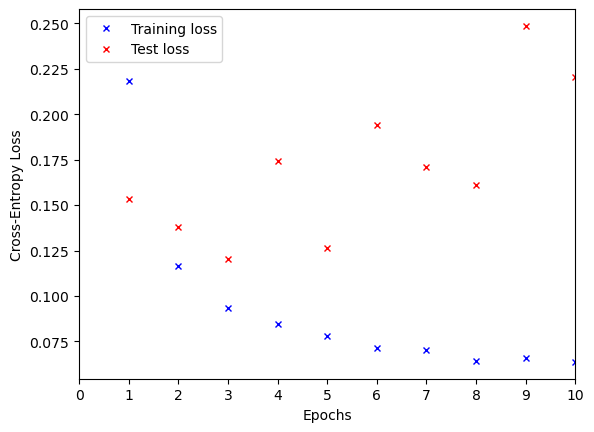

In [9]:
plt.plot(range(1,11), training_losses, 'bx', markersize=4, label='Training loss')
plt.plot(range(1,11), test_losses, 'rx', markersize=4, label='Test loss')

plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.xlim(0,10,1)
plt.xticks(range(11))

plt.legend()
plt.show()

For a quick visualization a picture from the testset can be loaded and fed through the network.

In [10]:
img, lbl = next(iter(testloader))

Here the image fed to the network is plotted.

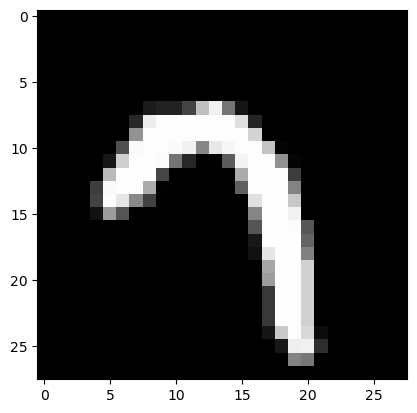

In [11]:
img_plt = img.squeeze()
plt.imshow(img_plt[0], cmap='gray')

The networks prediction will be right around 97% of the time. (See test accuracy above)

In [12]:
img = img.view(img.shape[0], -1)

print('Best guess:', torch.exp(model(img[0])).topk(1,dim=0)[1][0].tolist(), '(Second best:', str(torch.exp(model(img[0])).topk(2,dim=0)[1][1].tolist()) + ')')
print('Labeled:', lbl[0].tolist())

Best guess: 9 (Second best: 7)
Labeled: 7
